# Mounting Content from Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import necessary libraries and set the seeds

In [1]:
# Imports
import pandas as pd # data handling
import numpy as np # base of all
import matplotlib.pyplot as plt # plotting
import seaborn as sns  # advance plotting
from wordcloud import WordCloud # to see the words as image
import torch # PyTorch for building Networks
from torchtext.legacy.data import Field, LabelField, BucketIterator,TabularDataset  # TorchText has Text processing Function
from torchtext import vocab
from sklearn.model_selection import train_test_split # split the data into training and testing
from sklearn.metrics import accuracy_score # accuracy metric
from nltk import word_tokenize # very popular Text processing Library
import random # to perform randomisation of tasks
from tqdm.notebook import tqdm # for a continuous progress bar style
import time # time module 
import os # import operating system


SEED = 12345
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # cuda algorithms
os.environ['PYTHONHASHSEED'] = str(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use 'cuda' if available else 'cpu'
print('Working on:', device)

Working on: cuda


# Import datasets


Labels in dataset:
*   label 0: neutral
*   label 1: anti-vax
*   label 2: pro-vax







In [2]:
# train set
Train_set_Location = r'/content/vaccine_train_set.csv' 

# validation set
Validation_set_Location = r'/content/vaccine_validation_set.csv'  

df_train = pd.read_csv(Train_set_Location, index_col=0)
df_test = pd.read_csv(Validation_set_Location, index_col=0)

# Drop the rows where at least one element is missing
df_train.dropna()
df_test.dropna()

df_train.head(5)

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [3]:
print(df_train.shape)
print(df_test.shape)

(15976, 2)
(2282, 2)


In [4]:
# Save the preprocessed  tweets
df_train.to_csv(Train_set_Location)
df_test.to_csv(Validation_set_Location)

# Prepare the fields for vocabulary

# Creating GloVe vocabulary 
https://nlp.stanford.edu/projects/glove/

https://towardsdatascience.com/how-to-use-torchtext-for-neural-machine-translation-plus-hack-to-make-it-5x-faster-77f3884d95

In [5]:
from torchtext.legacy import data 

#Here we initialize two fields. One for the text (our features) and one for the labels.
text_field = data.Field(tokenize='spacy', lower=True) # Fix length is 40 so every batch can have the same length (needed for this model).
label_field = data.Field(sequential=False, use_vocab=False)


# Splitting with the TabularDataset module. This will allow us to also tokenize the text.
train_data, test_data = data.TabularDataset.splits(
                                        path='/content/',
                                        train = 'vaccine_train_set.csv',
                                        test = 'vaccine_validation_set.csv',
                                        format = 'csv',
                                        skip_header = True,
                                        fields=[(None, None), ('tweet', text_field), ('label', label_field)])

print('First line from training set:\n', vars(train_data.examples[0]))
print('\nFirst line from test set:\n', vars(test_data.examples[0]))

First line from training set:
 {'tweet': ['sip', 'n', 'shop', 'come', 'thru', 'right', 'now', '#', 'marjais', '#', 'popularnobodies', '#', 'mmr', '🙌', '🙌', '🙌', '🙌', '@', 'marjais', 'sipnshop', 'http://t.co/jfwah7uzwe'], 'label': '0'}

First line from test set:
 {'tweet': ['@user', 'they', 'had', 'a', 'massive', 'surge', 'in', 'with', 'covid', 'deaths', 'immediately', 'after', 'the', 'vaccine', 'rollout', ',', 'way', 'more', 'than', 'they', 'had', 'during', 'the', 'entirety', 'of', 'the', '"', 'pandemic', '"', 'up', 'to', 'that', 'point', '.', 'fuck', 'those', 'jabs', ',', 'dr', '.', 'death', '.'], 'label': '1'}


# BacketIterator

# Fields

In [6]:
text_field.build_vocab(train_data,
                       max_size=100000, 
                       vectors='glove.twitter.27B.100d',
                       unk_init = torch.Tensor.normal_) 

label_field.build_vocab(train_data) 

# words are stored as integers withn the vocab for internal data structure handling. 
# let us look at the {'word':respective_integer} of first 15 

print({k: text_field.vocab.stoi[k] for k in list(text_field.vocab.stoi)[:15]}) 
# this is just pure python code to get first N elements from a a dictonary, as a dictonary

{'<unk>': 0, '<pad>': 1, '.': 2, '#': 3, 'the': 4, 'to': 5, ',': 6, 'vaccine': 7, 'a': 8, ':': 9, 'measles': 10, 'of': 11, 'and': 12, 'i': 13, 'in': 14}


In [7]:
print(f"Most common 15 words in the vocab are: {text_field.vocab.freqs.most_common(15)}")
# integers i int the second part of each tuples are the frequencies of words in the vocab. They show that how many
# number of times this specific word has apprered in the whole training data set

Most common 15 words in the vocab are: [('.', 11395), ('#', 9497), ('the', 8689), ('to', 6895), (',', 6725), ('vaccine', 5091), ('a', 5015), (':', 4654), ('measles', 4442), ('of', 4330), ('and', 4023), ('i', 3908), ('in', 3826), ('!', 3747), ('is', 3467)]


In [10]:
train_iter, test_iter = BucketIterator.splits((train_data, test_data), batch_sizes=(128, 32),
                                              sort_key=lambda x: len(x.tweet),
                                              sort_within_batch=False,
                                              device=device) # use the cuda device if available

# Define the model

In [11]:
from torch.nn import functional as F

class DeepNetwork(torch.nn.Module):
    '''
    Deep RNN Network which can have either one both of stacked and bi-directional properties
    '''
    
    def __init__(self, vocab_size, embedding_dim=100, hidden_size=256, 
                 out_neuron=3, drop=0.53, n_layers=2, bidirectional=True, attention=True, m_type='lstm'):
        '''
        Constructor of the class which will instantiate the layers while initialisation.
        
        args:
            vocab_size: input dimensions of the first layer {int}
            embedding_dim: number of latent features you want to calculate from the input data {int} default=100
            hidden_size: neurons you want to have in your hidden RNN layer {int} default=256
            out_neuron: number of outputs you want to have at the end.{int} default=1
            model: whether to use 'lstm' or 'gru' {string} 
            drop: proportion of values to dropout from the previous values randomly {float 0-1} default=0.53
            attention: if you want to train the model with attention method 
        out: 
            return a tensor of shape {batch,out_neuron} as output 
        '''
        super(DeepNetwork,self).__init__()
        
        self.m_type = m_type
        self.attention = attention
        self.num_layers = n_layers
        
        self.embedding = torch.nn.Embedding(in_neuron,embedding_dim)
        self.hidden_size = hidden_size
        
        if self.m_type == 'lstm':
            self.lstm = torch.nn.LSTM(embedding_dim, hidden_size, num_layers=n_layers, bidirectional=True)
        elif self.m_type == 'gru':
            self.gru = torch.nn.GRU(embedding_dim, hidden_size, num_layers=n_layers, bidirectional=True)
        
        self.dropout = torch.nn.Dropout(drop) 
        
        self.dense1 = torch.nn.Linear(hidden_size*2, out_neuron)
        # Last output Linear Layer will have the two Hidden States from both the directions to have the result
        
    def attention_net(self, rnn_output, final_state):

        """ 
        Now we will incorporate Attention mechanism in our LSTM/GRU model. In this new model, we will use attention to compute soft alignment score corresponding
        between each of the hidden_state and the last hidden_state of the LSTM/GRU. We will be using torch.bmm for the batch matrix multiplication.
        
        Arguments
        ---------
        
        lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
        final_state : Final time-step hidden state (h_n) of the LSTM
        
        ---------
        
        Returns : It performs attention mechanism by first computing weights for each of the sequence present in rnn_output and and then finally computing the
              new hidden state.
              
        Tensor Size :
              hidden.size() = (batch_size, hidden_size)
              attn_weights.size() = (batch_size, num_seq)
              soft_attn_weights.size() = (batch_size, num_seq)
              new_hidden_state.size() = (batch_size, hidden_size)
                
        """
        hidden = final_state.squeeze(0)

        attn_weights = torch.bmm(rnn_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(rnn_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        
        return new_hidden_state


    def forward(self,t, batch_size):
        '''
        Activate the forward propagation
        args:
            t: tensors in the form of a batch {torch.tensor}
        '''
        t = self.dropout(self.embedding(t)) # get embeddings and dropout
    
        if self.m_type == 'lstm':
            out, (hidden,_) = self.lstm(t)
        elif self.m_type == 'gru':
            out, hidden = self.gru(t)

        curr_batch_size = batch_size[1]

        

        if self.attention == True:
          final_hidden_state = hidden.reshape(self.num_layers, curr_batch_size, -1)[0]  # get the correct shape for final hidden shape
          out = out.permute(1, 0, 2)    # = out.T
          attn_output = self.attention_net(out, final_hidden_state)
          
          t = self.dropout(attn_output)  

        elif self.attention == False:                                    # after attention
          # Concatenate the last and second last hidden. One is from backward and one is from forward
          t = self.dropout(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))    # before attention

        out = self.dense1(t)

        return out

# Tranning and evaluate the neural network

In [78]:
in_neuron = len(text_field.vocab)
lr = 3e-3 # learning rate = 0.0004
embedding_dim = 100
hidden_size = 125
num_layers = 2
out_classes = 3
Dropout = 0.4
bidirectional = True

# Add attention (question 2)
# Change this if you want to train the model without attention
attention = True

network = DeepNetwork(in_neuron, embedding_dim, hidden_size, out_classes, 
                      Dropout, num_layers, bidirectional, attention, m_type='gru')

optimizer = torch.optim.Adam(network.parameters(), lr=lr) # use Adam Optimizer
loss_fn = torch.nn.CrossEntropyLoss() 

# loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='mean')   # weights gave me worst results  
## Getting all embeddings from glove gave me worst results
# weights = text_field.vocab.vectors
# network.embedding.weights = torch.nn.Parameter(weights, requires_grad=False)

pretrained_embeddings = text_field.vocab.vectors  # get all the 100000+2 vectors
network.embedding.weight.data.copy_(pretrained_embeddings) #copy embeddings as the weights to the layer

unknown_index = text_field.vocab.stoi[text_field.unk_token] # get index of unknown token
padding_index = text_field.vocab.stoi[text_field.pad_token] # get index of padding token

network.embedding.weight.data[unknown_index] = torch.zeros(embedding_dim) #change values to zeros
network.embedding.weight.data[padding_index] = torch.zeros(embedding_dim)



if torch.cuda.is_available():
    network.cuda() # activate GPU spport
    

train_losses = []
test_losses =  []

EPOCHS = 3 

for epoch in range(EPOCHS):

    epoch_loss = [] # loss per epoch
    epoch_acc = [] # accuracy per epoch

    total_loss = []  # total loss for the whole incoming data
    total_acc = []   # total accuracy for the whole data
    
    
    
    network.train() # set the model in training mode as it requires gradients calculation and updtion
    with torch.set_grad_enabled(True):

      for batch in tqdm(train_iter,f"Epoch: {epoch+1}"): 
          # data will be shown to model in batches per epoch to calculate gradients per batch
          
          optimizer.zero_grad() # clear all the calculated grdients from previous step
          
          predictions = network(batch.tweet, batch.tweet.size()) # squeeze out the extra dimension [batch_size,1]


          loss = loss_fn(predictions, batch.label) # calculate loss on the whole batch
          

          _, pred_classes = torch.max(predictions, 1)   # from softmax we get the index of the maximum value 

          
          correct_preds = (pred_classes == batch.label).float()
          # get a floating tensors of predicted classes  which match original true class 
          
          accuracy = correct_preds.sum()/len(correct_preds) # it'll be a tensor of shape [1,]
          
          # below two are must and should be used only after calculation of Loss by optimizer
          loss.backward() # Start Back Propagation so that model can calculate gradients based on loss

          # gradient clipping
          torch.nn.utils.clip_grad_value_(network.parameters(), clip_value=0.2)


          optimizer.step() # update the weights based on gradient corresponding to each neuron
          
          
          epoch_loss.append(loss.item())  # add the loss for this batch to calculate the loss for whole epoch
          epoch_acc.append(accuracy.item()) # .item() tend to give the exact number from the tensor of shape [1,]

          time.sleep(0.001) # for tqdm progess bar


    train_loss, train_acc = np.mean(epoch_loss), np.mean(epoch_acc)

    
    network.eval() # set the model in evaluation mode to not compute gradients and reduce overhead
    with torch.no_grad(): # turn of gradients calculation 
        
        for batch in test_iter:

            predictions = network(batch.tweet, batch.tweet.size()).squeeze(1) # squeeze out the extra dimension [batch_size,1]

            loss = loss_fn(predictions, batch.label)

            _, pred_classes = torch.max(predictions, 1)

            correct_preds = (pred_classes == batch.label).float()

            accuracy = correct_preds.sum()/len(correct_preds)

            total_loss.append(loss.item()) 
            total_acc.append(accuracy.item())

      
    test_loss, test_acc = np.mean(total_loss), np.mean(total_acc)   # get the average test loss and the average accuracy

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    tqdm.write(f''' End of Epoch: {epoch+1}  |  Train Loss: {train_loss:.3f}  |  Val Loss: {test_loss:.3f}  |  Train Acc: {train_acc*100:.2f}%  |  Val Acc: {test_acc*100:.2f}% ''')

Epoch: 1:   0%|          | 0/125 [00:00<?, ?it/s]

 End of Epoch: 1  |  Train Loss: 0.826  |  Val Loss: 0.737  |  Train Acc: 61.72%  |  Val Acc: 67.04% 


Epoch: 2:   0%|          | 0/125 [00:00<?, ?it/s]

 End of Epoch: 2  |  Train Loss: 0.688  |  Val Loss: 0.661  |  Train Acc: 70.28%  |  Val Acc: 71.14% 


Epoch: 3:   0%|          | 0/125 [00:00<?, ?it/s]

 End of Epoch: 3  |  Train Loss: 0.586  |  Val Loss: 0.657  |  Train Acc: 75.88%  |  Val Acc: 72.18% 


## Predictions function

In [79]:
def get_scores(network, val_test_iter, optimizer, loss_fn):
    '''
    evaluate the network using given parameters
    args:
        network: any Neural Network object 
        val_test_iter: iterator of validation/test data
        loss_fn: appropriate loss function
    out:
        a tuple of (average_loss,average_accuracy) of floating values for the incoming dataset
    '''
    network.eval() # set the model in evaluation mode to not compute gradients and reduce overhead
    predict_labels = [] # the predicted labels
    targets = []        # the true labes
    preds_probs = []    # the predictions from network (based on cross entropy loss - ) 

    with torch.no_grad(): # turn of gradients calculation 
        
        for ind, batch in enumerate(val_test_iter):

            predictions = network(batch.tweet, batch.tweet.size())

            loss = loss_fn(predictions, batch.label)

            preds_probs.extend(predictions.tolist())

            h, pred_classes = torch.max(predictions, 1) # get the index of the maximum value for each label

            predict_labels.extend(pred_classes.tolist()) 
            targets.extend(batch.label.tolist())

    return predict_labels, targets, preds_probs

In [80]:
from sklearn import metrics

predictions, targets, preds_probs = get_scores(network, test_iter, optimizer, loss_fn)

print(metrics.classification_report(targets, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.814     0.764     0.788      1065
           1      0.513     0.588     0.548       296
           2      0.704     0.721     0.712       921

    accuracy                          0.724      2282
   macro avg      0.677     0.691     0.683      2282
weighted avg      0.731     0.724     0.727      2282



## Plot loss vs epoch

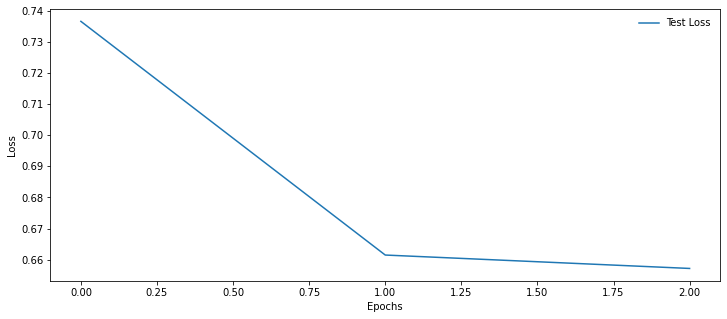

In [81]:
#Plotting loss vs epochs.
plt.figure(figsize=(12, 5))

plt.xlabel('Epochs')
plt.ylabel('Loss')
2
plt.plot(test_losses, label='Test Loss')
plt.legend(frameon=False)

# ROC curves


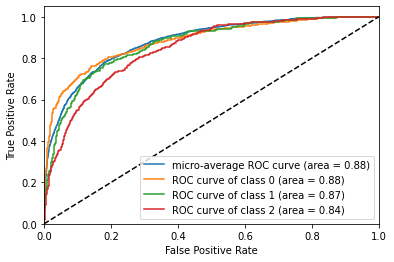

In [82]:
from torch.autograd import Variable
from sklearn.metrics import roc_curve,auc

predictions = torch.tensor(preds_probs)

# binarize the the labels
y_test_roc = []
for tweet in test_iter:
  for pred in tweet.label:
    if pred == 0:
      y_test_roc.append([1, 0, 0])
    elif pred == 1:
      y_test_roc.append([0, 1, 0])
    elif pred == 2:
      y_test_roc.append([0, 0, 1])


n_classes = 3
predictions = predictions
predictions = Variable(predictions, requires_grad=True)
predictions = predictions.detach().numpy()
y_test_roc = np.array(y_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()